In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rank_bm25
import nltk
from nltk import stem
import tqdm 
from mlutil.parallel import mapp
from toolz import partial

import rank_bm25
import pytrec_eval

plt.style.use('dark_background')

/etc/miniconda/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
W0111 12:16:45.123406 139681046181696 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
!pwd

/home/kuba/Projects/wikir_text_mining


In [3]:
!ls wikIR1k/training/

BM25.metrics.json  BM25.qrels.csv  BM25.res  qrels  queries.csv


## Documents

In [4]:
documents_df = pd.read_csv('wikIR1k/documents.csv', index_col='id_right')

In [5]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99987 entries, 0 to 99999
Data columns (total 1 columns):
text_right    99987 non-null object
dtypes: object(1)
memory usage: 1.5+ MB


In [6]:
documents_df.head()

,text_right
id_right,
0,these institutions are often described as stat...
1,parents usually notice signs during the first ...
2,a planet like earth it is dimensionless and me...
3,it is similar to the ancient greek letter alph...
4,it is bordered by tennessee to the north georg...


In [7]:
document_lengths = documents_df['text_right'].apply(lambda s: s.count(' '))

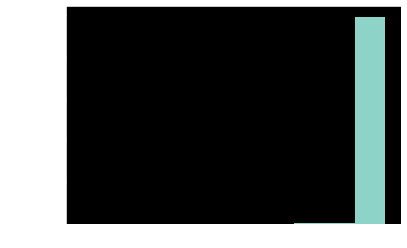

In [8]:
document_lengths.plot.hist();

## Queries

In [9]:
queries_df = pd.read_csv('wikIR1k/training/queries.csv', index_col='id_left')

In [10]:
queries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 17783 to 12052
Data columns (total 1 columns):
text_left    1645 non-null object
dtypes: object(1)
memory usage: 25.7+ KB


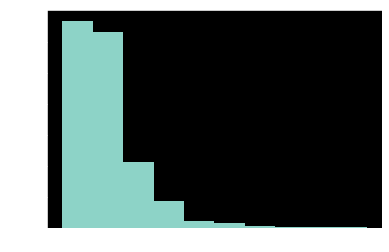

In [11]:
queries_df['text_left'].apply(lambda s: len(s.split())).plot.hist();

# BM25 results

In [12]:
!head wikIR1k/training/BM25.qrels.csv

,id_left,id_right,label
0,17783,77063,0
1,17783,17774,0
2,17783,17783,2
3,17783,20576,0
4,17783,77066,0
5,17783,35888,1
6,17783,77064,0
7,17783,97038,1
8,17783,29547,0


In [13]:
relevances = pd.read_csv('wikIR1k/training/BM25.qrels.csv')
relevant_pairs=relevances[relevances['label'] != 0]
relevant_pairs.shape

(8588, 4)

In [14]:
relevant_pairs.merge(queries_df, on='id_left').merge(documents_df, on='id_right')

,Unnamed: 0,id_left,id_right,label,text_left,text_right
0,2,17783,17783,2,apulia,the region comprises and its population is abo...
1,5,17783,35888,1,apulia,it also has two coastlines a 30 km stretch on ...
2,21902,17774,35888,1,calabria,it also has two coastlines a 30 km stretch on ...
3,37971,95944,35888,1,regions of italy,it also has two coastlines a 30 km stretch on ...
4,74818,17843,35888,1,campania,it also has two coastlines a 30 km stretch on ...
...,...,...,...,...,...,...
8583,164400,12052,29167,1,sonic youth,after graduating from los angeles s otis colle...
8584,164401,12052,88503,1,sonic youth,the band recorded the album between july and a...
8585,164403,12052,12052,2,sonic youth,founding members thurston moore guitar vocals ...
8586,164404,12052,29166,1,sonic youth,he has also participated in many solo and grou...


In [15]:
stop_words = set(nltk.corpus.stopwords.words('english'))


def get_document_stems(doc_with_key, stemmer):
    key, value = doc_with_key
    value = value['text_right']
    stems = [stemmer.stem(elem) for elem in value.split(" ") if elem not in stop_words]
    return key, stems #value.split() 


def make_bm25(documents, stemmer=stem.PorterStemmer()):
    docs_dict = dict(mapp(partial(get_document_stems, stemmer=stemmer), documents.iterrows()))
    return rank_bm25.BM25Okapi(docs_dict.values())

In [29]:
def make_relevance_dict(queries_df, relevant_indices):
    return {
        str(l): {
            str(k): v
            for (k, v) in relevant_indices[i].to_dict().items()
        }
        for i, l in enumerate(queries_df.index)
    }


def get_predicted_relevant_indices(queries_df, bm25, k=100):

    bm25_relevant_indices = []
    for __, q in tqdm.tqdm(queries_df.iterrows(), total=len(queries_df)):
        query = [nltk.stem.PorterStemmer().stem(t) for t in q['text_left'].split()]
        scores = bm25.get_scores(query)
        sorted_indices = np.argsort(scores)[::-1][:k]
        sorted_scores = scores[sorted_indices]
        document_indices = documents_df.index[sorted_indices]
        bm25_relevant_indices.append(pd.Series(sorted_scores, index=document_indices))
    
    return bm25_relevant_indices


def setup_evaluator_from_relevance_file(qrel_path, measures={"map","ndcg_cut","recall","P"}):
    with open(qrel_path, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    return pytrec_eval.RelevanceEvaluator(qrel,measures)


def get_results_df(predicted_relevance, evaluator):
    results = evaluator.evaluate(predicted_relevance)
    return pd.DataFrame.from_records(results).T

In [17]:
%%time
bm25 = make_bm25(documents_df)

CPU times: user 53.3 s, sys: 4.22 s, total: 57.5 s
Wall time: 1min 2s


In [18]:
documents_df

,text_right
id_right,
0,these institutions are often described as stat...
1,parents usually notice signs during the first ...
2,a planet like earth it is dimensionless and me...
3,it is similar to the ancient greek letter alph...
4,it is bordered by tennessee to the north georg...
...,...
99995,he was the first born son of constantine i and...
99996,they were the 2003 2006 and 2008 wnba champion...
99997,36 and dewitt clinton high school in the bronx...


In [19]:
qrels_all = pd.read_csv('wikIR1k/training/BM25.qrels.csv', index_col=0)
qrels = qrels_all[qrels_all['label'] != 0]

qrels_trec = qrels.groupby('id_left')['id_right'].apply(list)

id_left
4        [13565, 39189, 4, 38981, 39019, 38863, 38972, ...
6                                                  [20527]
9                      [86246, 24141, 24157, 85150, 24248]
22                                  [22, 572, 88364, 7955]
24                  [24, 29460, 7767, 29525, 29524, 29531]
                               ...                        
98402                                [98402, 64632, 62430]
98706                                              [50628]
98896                                       [90224, 87052]
99191                                [99191, 99192, 83289]
99815                         [99815, 77977, 80197, 85908]
Name: id_right, Length: 1240, dtype: object

In [20]:
n_tmp = 1000

In [21]:
qrels_trec_tmp = qrels_trec[:n_tmp].to_dict()

In [22]:
qrels_trec_tmp = {
    str(k): {str(v): 1 for v in vals}
    for (k, vals) in qrels_trec_tmp.items()
}

In [26]:
%%time

bm25_relevant_indices = get_predicted_relevant_indices(queries_df, bm25)
bm25_relevance_dict = make_relevance_dict(queries_df, bm25_relevant_indices)

100%|██████████| 1645/1645 [01:39<00:00, 16.56it/s]


CPU times: user 1min 39s, sys: 115 ms, total: 1min 39s
Wall time: 1min 39s


In [27]:
qrel_path = 'wikIR1k/training/qrels'
evaluator = setup_evaluator_from_relevance_file(qrel_path) 

In [30]:
results_df = get_results_df(bm25_relevance_dict, evaluator)

In [31]:
results_df.mean()

map              0.201171
P_5              0.329848
P_10             0.251672
P_15             0.209402
P_20             0.182614
P_30             0.146727
P_100            0.071866
P_200            0.035933
P_500            0.014373
P_1000           0.007187
recall_5         0.153343
recall_10        0.219016
recall_15        0.263900
recall_20        0.297221
recall_30        0.342009
recall_100       0.460801
recall_200       0.460801
recall_500       0.460801
recall_1000      0.460801
ndcg_cut_5       0.411034
ndcg_cut_10      0.379012
ndcg_cut_15      0.380193
ndcg_cut_20      0.385647
ndcg_cut_30      0.396099
ndcg_cut_100     0.431964
ndcg_cut_200     0.428129
ndcg_cut_500     0.426540
ndcg_cut_1000    0.426304
dtype: float64